In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, SubsetRandomSampler
import torch.nn as nn
from torchvision import datasets
import numpy as np
from PIL import Image
from pytorch_model_summary import summary
from torchvision.datasets.folder import pil_loader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

C:\Users\user\anaconda3\envs\my-torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


In [2]:
item = 'HeadCT'

In [24]:
import os
cwd = os.getcwd()
path = os.path.join(cwd, 'data')
path = os.path.join(path, 'Head_ct')
path = os.path.join(path, 'no')
#path = os.path.join(path, 'train')
#path = os.path.join(path, 'good')
#filename = os.path.join(path, '000.png')



In [25]:
img_h = 224
img_w = 224
# Wide-ResNet preprocessing
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize((img_h,img_w)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [5]:
class MyDataset(Dataset):
    def __init__(self, image_ids, image_dir, transform, target_transform=None):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image = pil_loader(os.path.join(self.image_dir, self.image_ids[index]))

        if self.transform:
            image = self.transform(image)

        x, y = image, image
        return x, y

    def __len__(self):
        return len(self.image_ids)



In [26]:
dataset = MyDataset(os.listdir(path), path, preprocess)
batch_size = 16
validation_split = 10/len(dataset)
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)


In [27]:
print(len(dataset))
print(len(train_loader.sampler))
print(len(validation_loader.sampler))


100
90
10


In [8]:
#Testing components generation:
from pytorch_model_summary import summary
from pkg.models import CustomResNet
# load WRN-50-2:
full_w_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
#encoder-architecture
enc = CustomResNet(model=full_w_resnet)
for param in enc.parameters():
    param.requires_grad = False
print(summary(enc, torch.zeros((1, 3, img_h, img_w))))

In [9]:
from pkg.models import OCBE, Bottleneck
ocbe = OCBE(Bottleneck, 3)
print(summary(ocbe, enc(torch.zeros((1, 3, img_h, img_w)))))

In [10]:
from pkg.models import de_wide_resnet50_2
decoder = de_wide_resnet50_2()
print(summary(decoder, ocbe(enc(torch.zeros((1, 3, img_h, img_w))))))


In [11]:
from pkg.models import ReverseDistillationModel
full_w_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet50_2', pretrained=True)
torch.cuda.empty_cache()
model = ReverseDistillationModel(encoder=CustomResNet(model=full_w_resnet),
                                 oceb=OCBE(Bottleneck, 3),
                                 decoder=de_wide_resnet50_2()).to(device)

print(summary(model, torch.zeros((1, 3, img_h, img_w)).to(device)))

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0


-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 64, 112, 112]           9,408               0
     BatchNorm2d-2     [1, 64, 112, 112]             128               0
            ReLU-3     [1, 64, 112, 112]               0               0
       MaxPool2d-4       [1, 64, 56, 56]               0               0
      Bottleneck-5      [1, 256, 56, 56]         206,336               0
      Bottleneck-6      [1, 256, 56, 56]         214,016               0
      Bottleneck-7      [1, 256, 56, 56]         214,016               0
      Bottleneck-8      [1, 512, 28, 28]         920,576               0
      Bottleneck-9      [1, 512, 28, 28]         854,016               0
     Bottleneck-10      [1, 512, 28, 28]         854,016               0
     Bottleneck-11      [1, 512, 28, 28]         854,016               0
     Bottleneck-12     [1, 1024, 14, 14]       3,6

In [16]:
import hiddenlayer as hl

hl_graph = hl.build_graph(model, torch.zeros((1, 3, img_h, img_w)).to('cuda'))
hl_graph.theme = hl.graph.THEMES["blue"].copy()
#hl_graph.save(path="model" , format="jpg")
hl_graph

-------------------------------------------------------------------------
      Layer (type)          Output Shape         Param #     Tr. Param #
          Conv2d-1      [1, 512, 28, 28]       1,179,648       1,179,648
     BatchNorm2d-2      [1, 512, 28, 28]           1,024           1,024
            ReLU-3      [1, 512, 28, 28]               0               0
          Conv2d-4     [1, 1024, 14, 14]       4,718,592       4,718,592
     BatchNorm2d-5     [1, 1024, 14, 14]           2,048           2,048
            ReLU-6     [1, 1024, 14, 14]               0               0
          Conv2d-7     [1, 1024, 14, 14]       4,718,592       4,718,592
     BatchNorm2d-8     [1, 1024, 14, 14]           2,048           2,048
            ReLU-9     [1, 1024, 14, 14]               0               0
     Bottleneck-10       [1, 2048, 7, 7]      11,282,432      11,282,432
     Bottleneck-11       [1, 2048, 7, 7]       4,462,592       4,462,592
     Bottleneck-12       [1, 2048, 7, 7]       4,4

In [18]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))


------------------------------------------------------------------------------
           Layer (type)          Output Shape         Param #     Tr. Param #
    DecoderBottleneck-1     [1, 1024, 14, 14]      11,016,192      11,016,192
    DecoderBottleneck-2     [1, 1024, 14, 14]       3,411,968       3,411,968
    DecoderBottleneck-3     [1, 1024, 14, 14]       3,411,968       3,411,968
    DecoderBottleneck-4      [1, 512, 28, 28]       2,755,584       2,755,584
    DecoderBottleneck-5      [1, 512, 28, 28]         854,016         854,016
    DecoderBottleneck-6      [1, 512, 28, 28]         854,016         854,016
    DecoderBottleneck-7      [1, 512, 28, 28]         854,016         854,016
    DecoderBottleneck-8      [1, 256, 56, 56]         689,664         689,664
    DecoderBottleneck-9      [1, 256, 56, 56]         214,016         214,016
   DecoderBottleneck-10      [1, 256, 56, 56]         214,016         214,016
   DecoderBottleneck-11      [1, 256, 56, 56]         214,016  

In [11]:
from torch import Tensor
from typing import List
def kd_loss(encoder_features: List[Tensor], decoder_features: List[Tensor], only_cos_distance = True, lam = 1e3) -> Tensor:
    """Computes cosine similarity loss based on features from encoder and decoder.
    Args:
    encoder_features (List[Tensor]): List of features extracted from encoder
    decoder_features (List[Tensor]): List of features extracted from decoder
    onlyCosDistance (def: True): Flag used to compute cosine distance or sum of it and Euclidean distance
    lam (def: 1e3): scale factor to keep the two loss factors on the same magnitude
    Returns:
    Tensor: Cosine similarity loss
    """
    cos_loss = torch.nn.CosineSimilarity()
    losses = list(map(cos_loss, encoder_features, decoder_features))
    euc_losses = [torch.dist(encoder_features[i], decoder_features[i], 2) for i in range(len(encoder_features))]
    loss_sum = 0
    for i, loss in enumerate(losses):
        if only_cos_distance:
            loss_sum += torch.mean(1 - loss)  # mean of cosine distance
        else:
            loss_sum += euc_losses[i] +lam*torch.mean(1 - loss)
    if not only_cos_distance:
        loss_sum *= 1e-3
    return loss_sum

In [15]:
from tqdm import trange
from time import sleep

# Model Initialization
torch.cuda.empty_cache()

# Using an Adam Optimizer with lr = 0.01
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr = 0.005,
                             betas=(0.5, 0.999))

save_path =  os.path.join(cwd, "SavedModels")
save_path =  os.path.join(save_path, "Checkpoints")


epochs = 200
outputs = []
losses = []
val_losses = []
count = 0
best_loss = np.inf
t = trange(range(epochs)[-1], desc="Epoch num %i")

#for epoch in range(epochs):
for epoch in t:
    t.set_description("Epoch num: %i" % epoch)
    t.refresh() # to show immediately the update
    sleep(0.01)
    for (image, _) in train_loader:

        image =  image.to(device)
        # Output of Teacher
        encoded = model.encoder(image)
        #Output of Student
        reconstructed = model.decoder(model.oceb(encoded))
        # Calculating the loss function
        loss = kd_loss(encoded, reconstructed, only_cos_distance= False)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #outputs.append((epochs, image, reconstructed))
    torch.cuda.empty_cache()
    # Storing the losses in a list for plotting
    losses.append(loss)
    comp_losses = []
    with torch.no_grad():
        for (image, _) in validation_loader:
            image =  image.to(device)
            # Output of Teacher
            encoded = model.encoder(image)
            #Output of Student
            reconstructed = model.decoder(model.oceb(encoded))
            # Calculating the loss function
            loss = kd_loss(encoded, reconstructed, only_cos_distance= False)
            comp_losses.append(loss)
        torch.cuda.empty_cache()
        val_losses.append(sum(comp_losses)/len(comp_losses))
        if val_losses[-1] >= best_loss:
            count +=1
        else:
            best_loss = val_losses[-1]
            count = 0
            ckpt_path =  os.path.join(save_path, '{1}_SavedModel_ckpt_{0}.pt'.format(epoch, item))
            torch.save(model.state_dict(),ckpt_path)
        if count >= 20:
            break

Epoch num: 179:  90%|████████▉ | 179/199 [04:36<00:30,  1.54s/it]


In [16]:
import datetime
time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

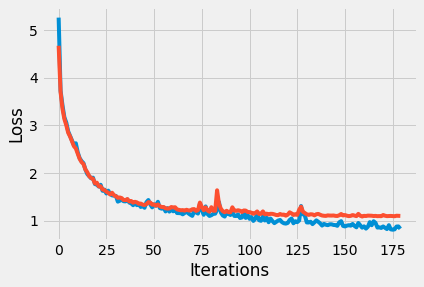

In [17]:
import matplotlib.pyplot as plt
cpu_losses = []
cpu_val_losses = []
for loss in losses:
    cpu_losses.append(loss.to('cpu').detach().numpy())
for loss in val_losses:
    cpu_val_losses.append(loss.to('cpu').detach().numpy())
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(cpu_losses)
plt.plot(cpu_val_losses)

plt.savefig('{1}_Training_{0}.png'.format(time, item))





In [36]:
save_path =  os.path.join(cwd, "SavedModels")
save_path =  os.path.join(save_path, '{1}_SavedModel{0}.pt'.format(time, item))
torch.save(model.state_dict(),save_path)

In [18]:
save_path =  os.path.join(cwd, "SavedModels")
save_path =  os.path.join(save_path, "Checkpoints")
model_path = os.path.join(save_path, "HeadCT_SavedModel_ckpt_159.pt")
model = ReverseDistillationModel(encoder=CustomResNet(model=full_w_resnet),
                                 oceb=OCBE(Bottleneck, 3),
                                 decoder=de_wide_resnet50_2())
model.load_state_dict(torch.load(model_path))
model.eval()



ReverseDistillationModel(
  (encoder): CustomResNet(
    (l1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(i

In [25]:
torch.cuda.empty_cache()

In [29]:
from PIL import Image
image = Image.new('RGB', (224, 224), (0, 0, 0))
image.save(os.path.join(cwd, "good_mask.png"), "PNG")

In [28]:
image_list = list()
gt_list = list()
path = os.path.join(cwd, "data")
test_path =  os.path.join(path, "Head_CT")



test_dirs = os.listdir(test_path)
for test_dir in test_dirs:
    cur_dir = os.path.join(test_path, test_dir)
    if "yes" in cur_dir:
        label = 1
        for i, file in enumerate(os.listdir(cur_dir)):
            image_list.append(os.path.join(cur_dir, file))
            gt_list.append(label)



In [20]:
class MyTestDataset(Dataset):
    def __init__(self, image_paths, ground_truth_paths, transform, target_transform=None, img_w = 224, img_h = 224):
        self.image_paths = image_paths
        self.ground_truth_paths = ground_truth_paths
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        image = pil_loader(self.image_paths[index])

        gt = self.ground_truth_paths[index]
        if self.transform:
            image = self.transform(image)

        x, y = image, gt
        return x, y

    def __len__(self):
        return len(self.image_paths)


In [21]:
#Compute AUROC
from sklearn.metrics import roc_curve, auc # roc curve tools
an_maps = list()
gts = list()

validation_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler)

for (image, _) in validation_loader:
    an_map = model.to("cpu").forward(image)
    gts.append(0)
    an_maps.append(torch.max(an_map.detach()))

print(len(an_maps))
print(len(gts))

preprocess = transforms.Compose([
    transforms.Resize((img_h,img_w)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = MyTestDataset(image_list, gt_list, preprocess)
batch_size = 1
validation_split = 1
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=valid_sampler)
print(len(dataset))
print(len(test_loader.sampler))

for (image, gt) in test_loader:
    an_map = model.to("cpu").forward(image)

    gts.append(gt)
    #for an_px in an_map.detach():
    #print(torch.max(an_map.detach()))
    an_maps.append(torch.max(an_map.detach()))

print(len(an_maps))
print(len(gts))

10
10
100
100
110
110


In [29]:
#Compute AUROC
#Here we are thresholding the LOSS instead of the anomaly detection score of RKD
from sklearn.metrics import roc_curve, auc # roc curve tools
an_maps = list()
gts = list()
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                                sampler=valid_sampler)
for (image, _) in validation_loader:
    encoded = model.encoder(image)
    #Output of Student
    reconstructed = model.decoder(model.oceb(encoded))
    # Calculating the loss function
    loss = kd_loss(encoded, reconstructed)
    gts.append(0)
    an_maps.append(loss.detach())

print(len(an_maps))
print(len(gts))

dataset = MyTestDataset(image_list, gt_list, preprocess)
batch_size = 1
validation_split = 1
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           sampler=valid_sampler)
print(len(dataset))
print(len(test_loader.sampler))

for (image, gt) in test_loader:
    encoded = model.encoder(image)
    #Output of Student
    reconstructed = model.decoder(model.oceb(encoded))
    # Calculating the loss function
    loss = kd_loss(encoded, reconstructed)
    gts.append(gt)
    #for an_px in an_map.detach():
    #print(torch.max(an_map.detach()))
    an_maps.append(loss.detach())

print(len(an_maps))
print(len(gts))


10
10
100
100
110
110


In [30]:
gts =  np.asarray(gts).astype(int)
fpr, tpr, thresholds = roc_curve(gts,an_maps)
roc_auc = auc(fpr,tpr)
#Compute  Youden’s J statistic wrt each threshold and sort results in decreasing order
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), thresholds)), key=lambda i: i[0], reverse=True)
print("Threshold sorted values are:", optimal_proba_cutoff[0])

Threshold sorted values are: (0.54, 0.6377338)


C:\Users\user\AppData\Local\Temp\ipykernel_4012\3506520834.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gts =  np.asarray(gts).astype(int)


Threshold optimal cutoff value is: 0.6377338


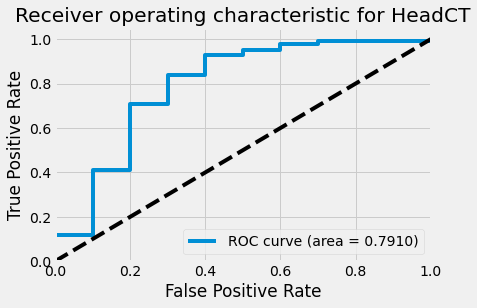

In [33]:


import matplotlib.pyplot as plt
#Plot AUROC and print best threshold
fig, ax = plt.subplots(1,1)
optimal_threshold = optimal_proba_cutoff[0][-1]#find_optimal_cutoff(fpr, tpr, thresholds)
print("Threshold optimal cutoff value is:", optimal_threshold)

ax.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic for {0}'.format(item))
ax.legend(loc="lower right")
fig.savefig(os.path.join(cwd, "ROC_{0}.png".format(item)))

In [26]:
#To calculate the per-region overlap, real-valued anomaly scores are thresholded to obtain a
# binary prediction for each pixel in the test set.
# Then, the percentage of correctly predicted pixels is computed for each annotated defect region
# in the ground-truth.
# The average over all defects yields the final PRO value.
#https://link.springer.com/article/10.1007/s11263-022-01578-9
def compute_pro(anomaly_map, ground_truth, threshold = 0.01):
    binary_class = list()
    correct_predicted = 0
    anomaly_region = 0
    for px in anomaly_map:
        #print("Anomaly map pixel: " + str(px))
        if px >= threshold:
            binary_class.append(1)
        else:
            binary_class.append(0)
    for i, px in enumerate(ground_truth):
        #print("GT pixel: "+ str(px))

        if px == 1:
            anomaly_region +=1
            if binary_class[i] == 1:
                correct_predicted += 1



    pro = correct_predicted/anomaly_region
    print("Correct predicted pixels: " + str(correct_predicted))
    print("Anomaly region pixels: " + str(anomaly_region))
    print("Predicted anomaly pixels: " + str(binary_class.count(1)))
    return pro

In [62]:
#Compute PRO
pro = compute_pro(an_maps, gts, optimal_threshold)
print(pro)

Correct predicted pixels: 286406
Anomaly region pixels: 413063
Predicted anomaly pixels: 1243491
0.69337122908612


In [47]:
image = pil_loader("data/Head_CT/no/104.png")
image = preprocess(image)
image = image[None, :]
anomaly_map = model.to('cpu').forward(image)

im = torch.swapaxes(image[0], 0, -1)
im = torch.swapaxes(im, 0, 1)
an_map = torch.swapaxes(anomaly_map[0], 0, -1)
an_map = torch.swapaxes(an_map, 0, 1)


print(im.shape)
print(an_map.shape)

torch.Size([224, 224, 3])
torch.Size([224, 224, 1])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


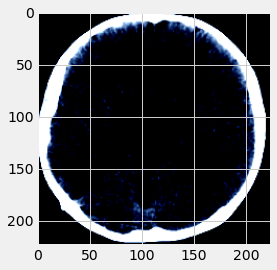

In [48]:
plt.imshow(im)

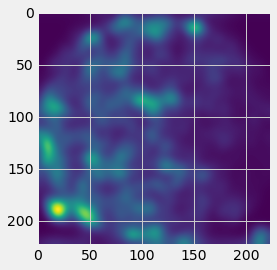

In [49]:
plt.imshow(an_map.detach().numpy())

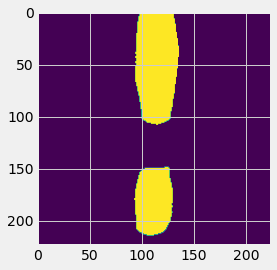

In [31]:
gt = pil_loader("data/mvtec_AD/zipper/ground_truth/combined/000_mask.png")
preprocess2 = transforms.Compose([
    #transforms.Resize((img_h,img_w)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485], std=[0.229]),
])

gt = gt.resize((img_w, img_h), Image.NEAREST)
gt = preprocess2(gt)
gt = torch.swapaxes(gt[0], 0, -1)
gt = torch.swapaxes(gt, 0, 1)
plt.imshow(gt)



In [38]:
import pandas as pd
def find_optimal_cutoff(fpr, tpr, threshold):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------
    list type, with optimal cutoff value

    """
    i = np.arange(len(tpr))
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold'])


